In [6]:
import sys
import os
import csv
import tempfile
import pandas as pd
import numpy as np
from pathlib import Path

# 导入tools模块中的函数
from tools import get_data_metrics, visualize

def is_zero_value(val_str):
    """检查值是否为零"""
    try:
        float_val = float(val_str)
        return abs(float_val) < 1e-10
    except (ValueError, TypeError):
        return val_str == '' or val_str == '0' or val_str == '0.0'

def remove_zero_column(file_path):
    """
    检查并移除倒数第二列全为0的列
    
    Parameters:
    -----------
    file_path : str
        要检查的CSV文件路径
    
    Returns:
    --------
    str
        如果移除了列，返回临时文件路径；否则返回原始文件路径
    """
    temp_file_path = None
    try:
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        
        if rows and len(rows[0]) > 1:
            # 检查倒数第二列是否全为0
            second_to_last_col_idx = -2
            second_to_last_col_values = []
            for row in rows:
                if len(row) > abs(second_to_last_col_idx):
                    val = row[second_to_last_col_idx].strip() if isinstance(row[second_to_last_col_idx], str) else str(row[second_to_last_col_idx])
                    second_to_last_col_values.append(val)
            
            is_all_zero = all(is_zero_value(val) for val in second_to_last_col_values) if second_to_last_col_values else False
            
            if is_all_zero:
                print(f"检测到倒数第二列全为0，创建临时文件并移除该列...")
                # 创建临时文件
                temp_fd, temp_file_path = tempfile.mkstemp(
                    suffix='.csv', 
                    prefix='generated_temp_', 
                    dir=os.path.dirname(file_path) or '.'
                )
                os.close(temp_fd)
                
                # 写入移除列后的数据
                with open(temp_file_path, 'w', newline='') as f_out:
                    writer = csv.writer(f_out)
                    for row in rows:
                        if len(row) > 1:
                            new_row = row[:second_to_last_col_idx] + row[second_to_last_col_idx+1:]
                            writer.writerow(new_row)
                        else:
                            writer.writerow(row)
                
                print(f"已创建临时文件: {temp_file_path}")
                return temp_file_path, True
            else:
                print(f"倒数第二列不全为0，使用原始文件")
                return file_path, False
    except Exception as e:
        print(f"检查文件时出错: {e}")
        import traceback
        traceback.print_exc()
        return file_path, False
    
    return file_path, False

def swap_last_two_columns_if_needed(file_path):
    """
    检查文件的最后两列是否为"samples, groups"，如果是则交换顺序为"groups, samples"
    
    Parameters:
    -----------
    file_path : str
        要检查的CSV文件路径
    
    Returns:
    --------
    str
        如果交换了列，返回临时文件路径；否则返回原始文件路径
    """
    temp_file_path = None
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            rows = list(reader)
        
        if rows and len(rows[0]) >= 2:
            header = rows[0]
            last_two_cols = header[-2:]
            
            # 检查最后两列是否为"samples"和"groups"
            if len(last_two_cols) == 2 and last_two_cols[0].strip() == 'samples' and last_two_cols[1].strip() == 'groups':
                print(f"检测到文件 {file_path} 的最后两列为'samples, groups'，正在交换顺序...")
                
                # 创建临时文件
                temp_fd, temp_file_path = tempfile.mkstemp(
                    suffix='.csv', 
                    prefix='swap_cols_temp_', 
                    dir=os.path.dirname(file_path) or '.'
                )
                os.close(temp_fd)
                
                # 写入交换列后的数据
                with open(temp_file_path, 'w', newline='', encoding='utf-8') as f_out:
                    writer = csv.writer(f_out)
                    for row in rows:
                        if len(row) >= 2:
                            # 交换最后两列
                            new_row = row[:-2] + [row[-1], row[-2]]
                            writer.writerow(new_row)
                        else:
                            writer.writerow(row)
                
                print(f"已创建交换列后的临时文件: {temp_file_path}")
                return temp_file_path, True
            else:
                print(f"文件 {file_path} 的最后两列不是'samples, groups'，无需交换")
                return file_path, False
        else:
            return file_path, False
    except Exception as e:
        print(f"检查文件 {file_path} 的列顺序时出错: {e}")
        import traceback
        traceback.print_exc()
        return file_path, False

def preprocess_generated_file(file_path):
    """
    预处理生成数据文件：去掉第一行表头
    
    Parameters:
    -----------
    file_path : str
        生成数据文件路径
    
    Returns:
    --------
    str
        临时文件路径（无表头）
    """
    try:
        df_gen = pd.read_csv(file_path, header=0)
        temp_fd, temp_file_path = tempfile.mkstemp(
            suffix='.csv', 
            prefix='generated_skip1_', 
            dir=os.path.dirname(file_path) or '.'
        )
        os.close(temp_fd)
        df_gen.to_csv(temp_file_path, index=False, header=False)
        return temp_file_path, True
    except Exception as e:
        print(f"去掉 generated 第一行时出错: {e}")
        return file_path, False


开始预处理文件...
倒数第二列不全为0，使用原始文件
检测到文件 /Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/SKCMPositive_5-2_test.csv 的最后两列为'samples, groups'，正在交换顺序...
已创建交换列后的临时文件: /Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/swap_cols_temp_r1wlm1ig.csv
文件 /Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/SKCMPositive_5-2_train_CVAE_augmented.csv 的最后两列不是'samples, groups'，无需交换

加载和预处理数据...
对生成数据进行log2转换...

开始可视化评估...


/opt/anaconda3/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


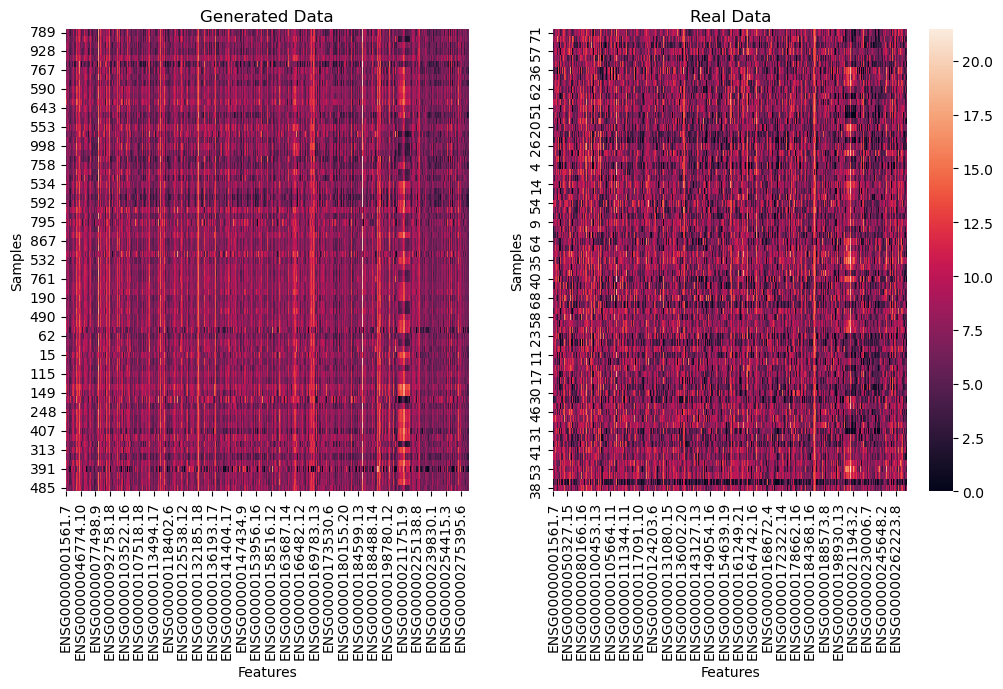

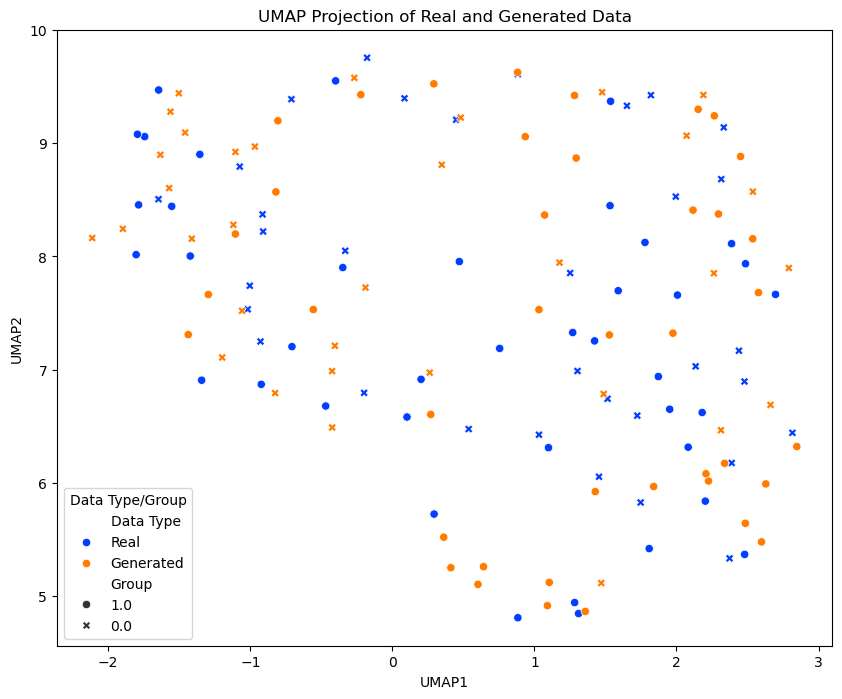


清理临时文件...
已删除临时文件: /Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/swap_cols_temp_r1wlm1ig.csv
已删除临时文件: /Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/generated_skip1__7tj3f8d.csv

评估完成！


In [12]:
# ====== 配置参数 ======
real_file_name = r"/Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/SKCMPositive_5-2_test.csv"

generated_file_name = r"/Users/yanjiechen/Documents/Github/SyNG-BTS_local/RNA-seq_augmentation/test/SKCMPositive_5-2_train_CVAE_augmented.csv"




# 生成数据是否为原始counts（需要log2转换）
# 注意：如果生成数据已经是log转换后的，设置为False
generated_is_raw_counts = True

# 可视化采样比例
visualize_ratio = 1.0

# 随机种子
random_seed = 88

# ====== 文件预处理 ======
temp_files_to_cleanup = []

print("=" * 60)
print("开始预处理文件...")
print("=" * 60)

# 1. 检查并移除全0列
generated_file_name, is_temp1 = remove_zero_column(generated_file_name)
if is_temp1:
    temp_files_to_cleanup.append(generated_file_name)

# 2. 检查并交换列顺序
real_file_name, is_temp2 = swap_last_two_columns_if_needed(real_file_name)
if is_temp2:
    temp_files_to_cleanup.append(real_file_name)

generated_file_name, is_temp3 = swap_last_two_columns_if_needed(generated_file_name)
if is_temp3:
    temp_files_to_cleanup.append(generated_file_name)

# 3. 去掉生成数据的第一行表头
generated_file_name, is_temp4 = preprocess_generated_file(generated_file_name)
if is_temp4:
    temp_files_to_cleanup.append(generated_file_name)

# ====== 加载和预处理数据 ======
print("\n" + "=" * 60)
print("加载和预处理数据...")
print("=" * 60)

real_data, groups_real, generated_data, groups_generated, unique_types = get_data_metrics(
    real_file_name, 
    generated_file_name
)

# 如果生成数据是原始counts，进行log2转换
if generated_is_raw_counts:
    print("对生成数据进行log2转换...")
    generated_data = pd.DataFrame(
        np.log2(generated_data.astype(float).values + 1), 
        index=generated_data.index, 
        columns=generated_data.columns
    )

# ====== 可视化评估 ======
print("\n" + "=" * 60)
print("开始可视化评估...")
print("=" * 60)

visualize(
    real_data, 
    groups_real, 
    unique_types, 
    generated_data, 
    groups_generated, 
    ratio=visualize_ratio, 
    seed=random_seed
)

# ====== 清理临时文件 ======
print("\n" + "=" * 60)
print("清理临时文件...")
print("=" * 60)

for temp_file in temp_files_to_cleanup:
    if temp_file is not None and os.path.exists(temp_file):
        try:
            os.remove(temp_file)
            print(f"已删除临时文件: {temp_file}")
        except Exception as e:
            print(f"删除临时文件 {temp_file} 时出错: {e}")

print("\n" + "=" * 60)
print("评估完成！")
print("=" * 60)
